<a href="https://colab.research.google.com/github/Inkering/Educational-Exploratory-Data-Analysis/blob/master/US_Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Scores of U.S. 8th Graders
By Case

In this project, I use school statistics to predict national math test scores. This project is an exploration of what school statistics correlate the most with typical 'achievement' metrics, in order to see where students (and their schools) need more help for that 'achievement' or the possible bias in those 'achievement' metrics.

## Background

**Database:** To get national U.S. public school data, I used this kaggle dataset https://www.kaggle.com/noriuk/us-education-datasets-unification-project/data#

The kaggle dataset has National Assessment of Educational Progress (NAEP) math and english scores, National Center for Education Statistics (NCES) enrollment, gender breakdown, and race demographic information, U.S. census finance information. The information is by state from years 1992 to 2017. 

**Algorithm:** I used sklearn's linear regression on different school information vs. 8th grade math test scores. I found co-efficients for the correlations between these factors and results, and did a train/test set in order to validate that the factors could predict test scores.

**Implications and Context** The state of education in the U.S. right now is one that is divided. Test scores and achievement varies greatly from state to state, and much within the schools and students of those states. My hope for this project was to do some research on what factors correlate with that very different achievement and to find possible explanations for the gaps. Research into those achievement gaps could go towards plans to close the gap or change the achievement metric to be more fair towards everyone.

## Imports and downloads

In [0]:
# Database downloading and framework
import gdown
import pandas as pd

# Graphing/correlation exploration
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# Linear regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Here I download the dataset, unzip the main file, and create the database from a csv to work with later on

In [2]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1qno1ugZdSDLS4UnI89VpQZl2fVpbQO50&export=download', 'us-education-dataset.zip', False)


Downloading...
From: https://drive.google.com/uc?authuser=0&id=1qno1ugZdSDLS4UnI89VpQZl2fVpbQO50&export=download
To: /content/us-education-dataset.zip
91.6MB [00:01, 81.9MB/s]


'us-education-dataset.zip'

In [0]:
# Unzip datasets
!unzip -qq -o us-education-dataset.zip
#https://drive.google.com/file/d/1qno1ugZdSDLS4UnI89VpQZl2fVpbQO50/view?usp=sharing
#https://drive.google.com/drive/folders/1AsWUQORymT2BeCBVdyk5X8B5RA20d3Um?usp=sharing
#https://drive.google.com/file/d/1Z_rAAy-3UCK3yy-c9_Mxnx7Z34oxGwNL/view?usp=sharing

In [0]:
states_full_key = pd.read_csv('states_all_extended.csv')

## Create Databases and Explore

The states_all_extended.csv which was saved as the states_full_key contains the following information that I use for analysis. 

STATE - the state the data is for

YEAR - year the information was collected

TOTAL_REVENUE - the total revenue for the state

GRADES_8 - total number of 8th grade students in the state

AVG_MATH_8_SCORE - the state's average score for 8th graders taking the NAEP math exam

GRADES_8_IN - total number of 8th grade students in the state of a specific demographic (sex or race), IN is a stand in for the initial of that demographic. Initials explained below
- AM (American Indian or Alaska Native)
- AS (Asian)
- HI (Hispanic/Latino)
- BL (Black or African American) 
- WH (White)
- HP (Hawaiian Native/Pacific Islander)
- TR (Two or More Races) 
- Sex: M (Male) and F (Female)



In [5]:
print(len(states_full_key))
states_full_key.head()

1492


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,GRADES_PK_AM,GRADES_KG_AM,GRADES_4_AM,GRADES_8_AM,GRADES_12_AM,GRADES_1_8_AM,GRADES_9_12_AM,GRADES_ALL_AM,GRADES_PK_AS,GRADES_KG_AS,GRADES_4_AS,GRADES_8_AS,GRADES_12_AS,GRADES_1_8_AS,GRADES_9_12_AS,GRADES_ALL_AS,GRADES_PK_HI,GRADES_KG_HI,GRADES_4_HI,...,GRADES_12_WHF,GRADES_1_8_WHF,GRADES_9_12_WHF,GRADES_ALL_WHF,GRADES_PK_HPM,GRADES_KG_HPM,GRADES_4_HPM,GRADES_8_HPM,GRADES_12_HPM,GRADES_1_8_HPM,GRADES_9_12_HPM,GRADES_ALL_HPM,GRADES_PK_HPF,GRADES_KG_HPF,GRADES_4_HPF,GRADES_8_HPF,GRADES_12_HPF,GRADES_1_8_HPF,GRADES_9_12_HPF,GRADES_ALL_HPF,GRADES_PK_TRM,GRADES_KG_TRM,GRADES_4_TRM,GRADES_8_TRM,GRADES_12_TRM,GRADES_1_8_TRM,GRADES_9_12_TRM,GRADES_ALL_TRM,GRADES_PK_TRF,GRADES_KG_TRF,GRADES_4_TRF,GRADES_8_TRF,GRADES_12_TRF,GRADES_1_8_TRF,GRADES_9_12_TRF,GRADES_ALL_TRF,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,NaN,174053.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,NaN,172.0,460.0,625.0,446.0,3930.0,2069.0,NaN,NaN,307.0,346.0,306.0,249.0,2651.0,1156.0,NaN,NaN,220.0,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,350902.0,NaN,37451.0,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,1457.0,2624.0,2175.0,1853.0,1323.0,17664.0,6391.0,25512.0,55.0,395.0,389.0,367.0,324.0,3090.0,1350.0,4495.0,26.0,229.0,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,1007732.0,NaN,609114.0,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,250.0,3674.0,3946.0,3230.0,2234.0,30133.0,10686.0,41069.0,20.0,754.0,822.0,734.0,823.0,6446.0,3340.0,9806.0,718.0,15501.0,14877.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,483488.0,NaN,145212.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,2.0,84.0,84.0,146.0,67.0,828.0,382.0,1212.0,7.0,199.0,214.0,216.0,224.0,1792.0,902.0,2701.0,11.0,370.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,8520926.0,NaN,2044688.0,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,NaN,2954.0,3079.0,2912.0,2434.0,24697.0,12820.0,NaN,NaN,41763.0,46079.0,40852.0,39036.0,356001.0,169604.0,NaN,NaN,170998.0,152087.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.398961,260.892247,196.764414,NaN


## Creating a Smaller Database

Since the original database that I downloaded had a lot of columns in it, for easier management I created a smaller database with just the columns I wanted to use.

In [6]:
db = states_full_key[['PRIMARY_KEY','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']].copy()
db.head()

,PRIMARY_KEY,TOTAL_REVENUE,AVG_MATH_8_SCORE,GRADES_8_BL,GRADES_8_AS,GRADES_8_HI,GRADES_8_AM,GRADES_8_WH,GRADES_8_G
0,1992_ALABAMA,2678885.0,252.187522,20816.0,306.0,164.0,625.0,35854.0,58025.0
1,1992_ALASKA,1049591.0,NaN,422.0,367.0,182.0,1853.0,5965.0,8789.0
2,1992_ARIZONA,3258079.0,265.366278,1888.0,734.0,12964.0,3230.0,30265.0,49081.0
3,1992_ARKANSAS,1711959.0,256.312090,8828.0,216.0,233.0,146.0,26588.0,36011.0
4,1992_CALIFORNIA,26260025.0,260.892247,32319.0,40852.0,124766.0,2912.0,162447.0,363296.0


TOTAL_REVENUE is based on the size of the state, so create a metric that I could compare states by, I found the revenue per student for each state.

In [0]:
def per_student(total, enrolled):
  return total/enrolled

In [0]:
db['REVENUE_PER_STUDENT'] =  list(map(per_student, db['TOTAL_REVENUE'],db['GRADES_8_G']))

The represented races of the database are AM (American Indian or Alaska Native), AS (Asian), HI (Hispanic/Latino), BL (Black), WH (White), HP (Pacific Islander), and TR (Two or More Races). HP and TR are null in the database and so were not included here. 

I had the same issue as I did with total revenue, that the number of students for a race would be dependent on school/state size, so I found the percentage of each racial demographic for the state.

In [0]:
def race_percent(num_race, total):
  if num_race == None or total == None:
    return 0
  else:
    return float(num_race)/float(total)

In [0]:
db['AS_PER'] =  list(map(race_percent, db['GRADES_8_AS'],db['GRADES_8_G']))
db['BL_PER'] =  list(map(race_percent, db['GRADES_8_BL'],db['GRADES_8_G']))
db['AM_PER'] =  list(map(race_percent, db['GRADES_8_AM'],db['GRADES_8_G']))
db['WH_PER'] =  list(map(race_percent, db['GRADES_8_WH'],db['GRADES_8_G']))
db['HI_PER'] =  list(map(race_percent, db['GRADES_8_HI'],db['GRADES_8_G']))

I then cleaned up the small database by getting rid of unnecessary columns and dropping rows with null values.

In [11]:
db = db.drop(columns=['TOTAL_REVENUE', 'GRADES_8_AS', 'GRADES_8_BL','GRADES_8_AM','GRADES_8_WH','GRADES_8_HI'])
db = db.dropna(axis=0, how="any") #just replace null values
db

,PRIMARY_KEY,AVG_MATH_8_SCORE,GRADES_8_G,REVENUE_PER_STUDENT,AS_PER,BL_PER,AM_PER,WH_PER,HI_PER
0,1992_ALABAMA,252.187522,58025.0,46.167773,0.005274,0.358742,0.010771,0.617906,0.002826
2,1992_ARIZONA,265.366278,49081.0,66.381675,0.014955,0.038467,0.065810,0.616634,0.264135
3,1992_ARKANSAS,256.312090,36011.0,47.539891,0.005998,0.245147,0.004054,0.738330,0.006470
4,1992_CALIFORNIA,260.892247,363296.0,72.282725,0.112448,0.088961,0.008016,0.447148,0.343428
5,1992_COLORADO,272.398433,45025.0,70.742321,0.021521,0.052438,0.009062,0.752737,0.164242
...,...,...,...,...,...,...,...,...,...
1224,2015_VIRGINIA,287.709299,95221.0,166.533895,0.067916,0.227712,0.002867,0.517428,0.134141
1225,2015_WASHINGTON,286.513108,79483.0,172.482694,0.076935,0.044387,0.013563,0.571820,0.215845
1226,2015_WEST_VIRGINIA,271.450709,20426.0,170.292813,0.006854,0.050083,0.001028,0.910164,0.014247
1227,2015_WISCONSIN,289.077749,61084.0,190.514308,0.035967,0.091808,0.012491,0.725837,0.108081


## Linear Regression

Once I have the database with the columns I want, I then do linear regression. The linear_regression function below is used to find co-efficients for linear regression plots. The fit_model function trains a linear regression model on training data and then finds accuracy on testing data in order to validate that test scores can be predicted from the X variables. 

NAEP test scores are out of 500 points and are not a binary metric. Because of this, I rate accuracy by if the predicted scores are within 10 points (2% error) of the actual scores.

In [0]:
def linear_regression(X, y):
    # Returns correlation co-efficients between X variables and y output
    w, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
    return w

In [0]:
def fit_model(dfx, dfy, cols):
    # Prints test and train accuracy from linear regression model
    X_train, X_test, y_train, y_test = \
        train_test_split(dfx[cols], dfy) 
    # Split may be biased because points are close together in time

    model = LinearRegression()
    model.fit(X_train, y_train)
    # I commented out print lines because I already evaluated co-efficients
    #for i, c in enumerate(cols):
    #  print('w_%d (the weight for %s) = %f' % (i+1, c, model.coef_[i])) #coeffs
    #print('w_%d (the weight for the bias term) = %f' % (len(cols) + 1, model.intercept_)) #bias

    # Because y is not binary, I use a 2% margin of error to value correctness of prediction
    print('Accuracy on training set', (abs(model.predict(X_train) - y_train)<10).mean())
    print('Accuracy on testing set', (abs(model.predict(X_test) - y_test)<10).mean())
    return model

### Plots and Co-efficients

Below I create plots for the correlation between each factor and math score. This allows me to visualization if correlation co-efficients are reasonable or if they are biased by outliers/non-linear trends. After that, I use linear regression to find correlation co-efficients and compare those to the plots.

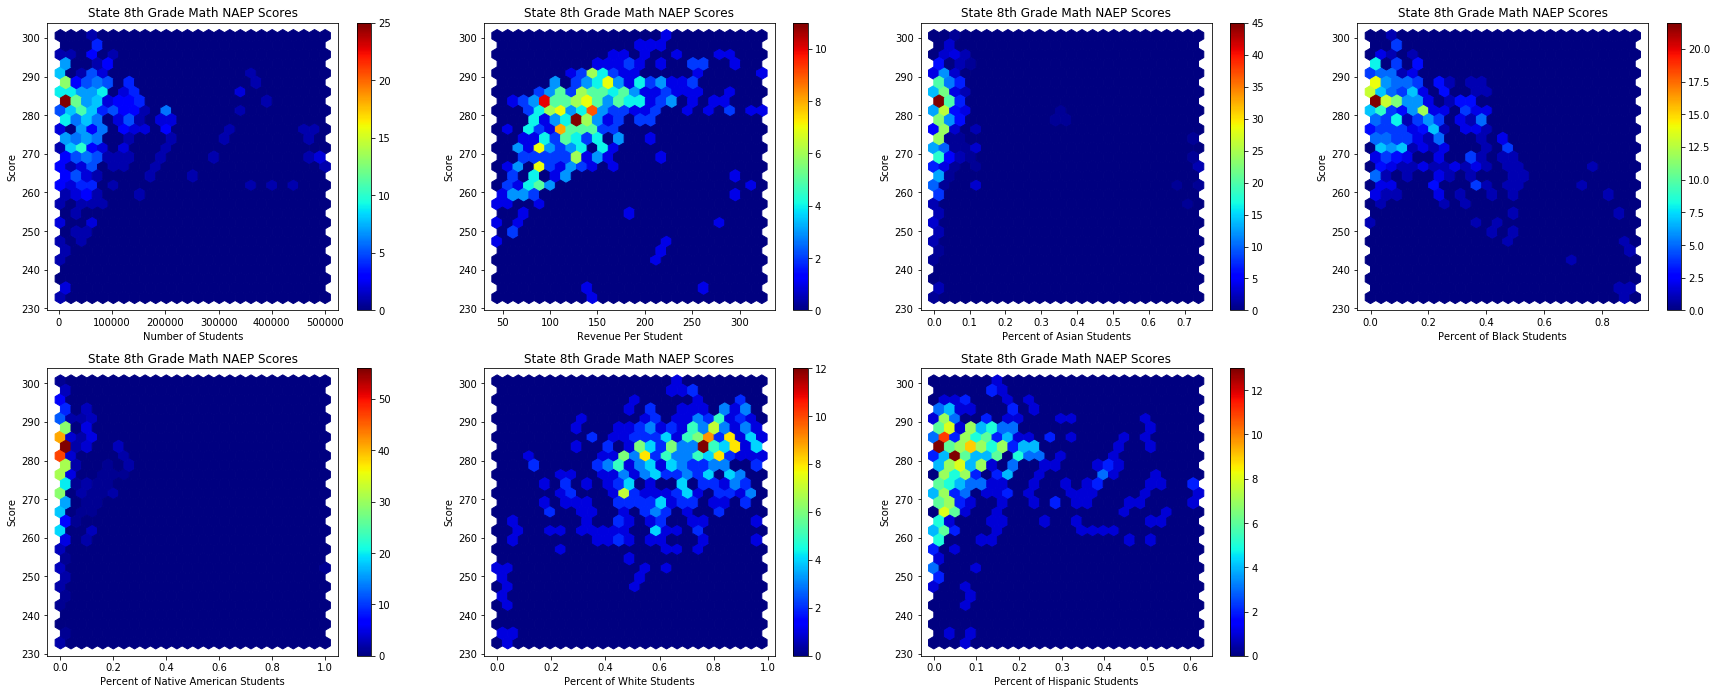

In [14]:
X_ed = db.drop(columns=['PRIMARY_KEY', 'AVG_MATH_8_SCORE'])
X_ed_labels = ['Number of Students', 'Revenue Per Student', 'Percent of Asian Students', 'Percent of Black Students', 'Percent of Native American Students','Percent of White Students','Percent of Hispanic Students']
y_ed = db['AVG_MATH_8_SCORE']

plt.figure(figsize=(30, 18)) #add this to make images high res -> ,dpi=300)
for idx, col in enumerate(X_ed):
    plt.subplot(3, 4, idx+1)
    plt.hexbin(X_ed[col], y_ed, gridsize=25, cmap='jet')
    plt.colorbar()
    plt.xlabel(X_ed_labels[idx])
    plt.ylabel('Score')
    plt.title('State 8th Grade Math NAEP Scores')

plt.subplots_adjust(wspace=.2)
plt.show()

From the plots I can see that there's a clear correlation with revenue per student and percentage of white students. There's also some correlation with black and hispanic students. Native american and asian students have such a low percentage in states that there is almost no distribution so it's hard to find any correlation.

Next I find the correlation co-efficients for the factors.

In [15]:
X_ed['bias'] = 1
list(zip(linear_regression(X_ed, y_ed), X_ed.columns))

[(1.0320848816080138e-05, 'GRADES_8_G'),
 (0.09337335108015266, 'REVENUE_PER_STUDENT'),
 (-27.23527624166463, 'AS_PER'),
 (-43.527897159384906, 'BL_PER'),
 (-36.35952182442289, 'AM_PER'),
 (0.9564585504714459, 'WH_PER'),
 (-14.579892664945627, 'HI_PER'),
 (274.3205873550629, 'bias')]

Native american and asian percentages show a higher correlation co-efficient than they should. This is due to their low poplulations and a few higher score outliers, that create an artificial downward correlation trend. 

White percentage and revenue per student show a lower co-efficient than I would expect, possibly due to scattering with some of the points that may make it seem like a weaker correlation. 

Black and hispanic percentage co-efficients are fairly reasonable, but perhaps stronger than I would expect when compared to my predictions for white percentage and revenue per student.

### Train/Test Linear Regression

In this section, I find the training and test accuracy for different run throughs of the linear regression model. I run the model with different x variables (2 variables each time) to see what variables are the best are predicting test scores, and the most consistent from test between train accuracy (deeper prediction, not surface level).

In [16]:
#X_cols defines x variables for run, and then I run the train/test linear regression model
X_cols = ['REVENUE_PER_STUDENT','WH_PER']
fit_model(X_ed, y_ed,X_cols);

Accuracy on training set 0.8333333333333334
Accuracy on testing set 0.8728813559322034


Revenue per student with white student percentage is the best predictor for student test scores of the 2 variable linear regressions I run below. It is also the most consistent from train to test scores.

To explore how different racial demographics compare as predictors, I did linear regressions with different combinations of race predictors. The first linear regression is just with revenue per student, as a baseline.

In [39]:
print(' Rev')
X_cols = ['REVENUE_PER_STUDENT']
fit_model(X_ed, y_ed,X_cols);

print(' Rev & Black')
X_cols = ['REVENUE_PER_STUDENT','BL_PER']
fit_model(X_ed, y_ed,X_cols);
print(' Rev & Hispanic')
X_cols = ['REVENUE_PER_STUDENT','HI_PER']
fit_model(X_ed, y_ed,X_cols);
print(' Rev & Native')
X_cols = ['REVENUE_PER_STUDENT','AM_PER']
fit_model(X_ed, y_ed,X_cols);
print(' Rev & Asian')
X_cols = ['REVENUE_PER_STUDENT','AS_PER']
fit_model(X_ed, y_ed,X_cols);

print(' Rev & non-white')
X_cols = ['REVENUE_PER_STUDENT','BL_PER','HI_PER','AM_PER','AS_PER']
fit_model(X_ed, y_ed,X_cols);

 Rev
Accuracy on training set 0.751412429378531
Accuracy on testing set 0.8389830508474576
 Rev & Black
Accuracy on training set 0.8361581920903954
Accuracy on testing set 0.847457627118644
 Rev & Hispanic
Accuracy on training set 0.7740112994350282
Accuracy on testing set 0.7711864406779662
 Rev & Native
Accuracy on training set 0.7598870056497176
Accuracy on testing set 0.8135593220338984
 Rev & Asian
Accuracy on training set 0.7994350282485876
Accuracy on testing set 0.7966101694915254
 Rev & non-white
Accuracy on training set 0.867231638418079
Accuracy on testing set 0.864406779661017


Of the racial demographic predictors, percentage of Black students was the best predictor with around 84% accuracy, slightly below the accuracy from percentage of white students. 

The rest of the race predictors slightly improved the accuracy of the regression but were not very good predictors by themselves. However, when the racial demographic predictors were combined, the regression was around 88% accurate, which is better than percentage of white students at predicting. 

In [41]:
X_cols = ['GRADES_8_G','WH_PER']
fit_model(X_ed, y_ed,X_cols);

Accuracy on training set 0.7598870056497176
Accuracy on testing set 0.7796610169491526


When revenue per student is removed as a predictor, the accuracy drops 10% percent, showing how revenue per student is a good predictor. The test also gets less consistent with the training accuracy without having two solid predictors.

## Results

I found that of the factors I looked at, the percentage of non-white students and the total revenue of the state were correlated the most with NAEP math scores for 8th grade students. These two factors were also the best at predicting the test scores, with a test accuracy of 88% and margin of error of 2%. 

When running a regression with only 2 predictors, total revenue paired with either percentage of white students or percentage of Black students had a good ability to predict math scores, with about 85% test accuracy. I think that the percentage of white or black students was a better indicator than other demographics because those groups have larger percentages in the U.S. and so capture more of the trends in the dataset than races with smaller percentages. Also, percentage of Black students captures the specific institutional oppression towards them. 

I believe that the percentage of white (or non-white) students and the total revenue of the state correlate highly with NAEP math scores because of institutional racism in creating the test and because poorer states/students are not able to afford the same quality of teachers/teaching materials/etc. Coming into this project, I thought that race and wealth might play a factor in test scores, but did not realize how much of an indication they would be. 

Schools should be given more funding based on need and there needs to be more programs seeking to help underprivileged students of minority backgrounds.

## 1992 specific exploration

This exploration was done before the results above (which are done with all years). It was used to figure out appropriate data columns/information for correlation and regression.

### 1992 database

Exploration of what columns to include in a database for future correlation exploration. Also, how to narrow down, clean, and make better metrics from existing data.

To visualize revenues and scores for states (year 1992):

In [19]:
#states_full_key[(states_full_key['YEAR'] == 1992)] gets all rows where year == 1992
revs_1992 = states_full_key[(states_full_key['YEAR'] == 1992)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE','GRADES_8_G']]
print(revs_1992.head())
revs_2005 = states_full_key[(states_full_key['YEAR'] == 2005)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE','GRADES_8_G']]
print(revs_2005.head())

      STATE  TOTAL_REVENUE  AVG_MATH_8_SCORE  GRADES_8_G
0   ALABAMA      2678885.0        252.187522     58025.0
1    ALASKA      1049591.0               NaN      8789.0
2   ARIZONA      3258079.0        265.366278     49081.0
3  ARKANSAS      1711959.0        256.312090     36011.0
5  COLORADO      3185173.0        272.398433     45025.0
                    STATE  TOTAL_REVENUE  AVG_MATH_8_SCORE  GRADES_8_G
664                ALASKA      1599739.0        278.958709     10793.0
666              ARKANSAS      3978240.0        271.636348     37279.0
670              DELAWARE      1431710.0        280.953543     10492.0
671  DISTRICT_OF_COLUMBIA      1109605.0        245.215781      5196.0
674                HAWAII      2274166.0        265.629319     13696.0


Add a column for revenue per students. Total revenue is not a very helpful metric because it depends a lot on the state population, where larger states will have more revenue. Per students makes it a better state to state comparison.

In [0]:
revs_1992['REVENUE_PER_STUDENT'] =  list(map(per_student, revs_1992['TOTAL_REVENUE'],revs_1992['GRADES_8_G']))
#print(revs_1992.head())
revs_2005['REVENUE_PER_STUDENT'] =  list(map(per_student, revs_2005['TOTAL_REVENUE'],revs_2005['GRADES_8_G']))
#print(revs_2005.head())

Create a database to store race percent/demographics for schools

In [21]:
#To see what columns hold data
states_full_key[(states_full_key['YEAR'] == 1992)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','GRADES_8_AS', 'GRADES_8_BL','GRADES_8_AM', 'GRADES_8_WH','GRADES_8_HI','GRADES_8_HP', 'GRADES_8_TR']].head()

,STATE,GRADES_8_AS,GRADES_8_BL,GRADES_8_AM,GRADES_8_WH,GRADES_8_HI,GRADES_8_HP,GRADES_8_TR
0,ALABAMA,306.0,20816.0,625.0,35854.0,164.0,NaN,NaN
1,ALASKA,367.0,422.0,1853.0,5965.0,182.0,NaN,NaN
2,ARIZONA,734.0,1888.0,3230.0,30265.0,12964.0,NaN,NaN
3,ARKANSAS,216.0,8828.0,146.0,26588.0,233.0,NaN,NaN
5,COLORADO,969.0,2361.0,408.0,33892.0,7395.0,NaN,NaN


Based on this representation of the table, white(WH), Black(BL), native americans(AM),asian(AS), and hispanic(HI) demographics exist. HP and TR do not, and so won't be used.

In [22]:
revs_demo_1992 = states_full_key[(states_full_key['YEAR'] == 1992)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']]
print(revs_demo_1992.head())
revs_demo_2005 = states_full_key[(states_full_key['YEAR'] == 2005)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']]
print(revs_demo_2005.head())
revs_demo_2015 = states_full_key[(states_full_key['YEAR'] == 2015)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']]
print(revs_demo_2015.head())

      STATE  TOTAL_REVENUE  ...  GRADES_8_WH  GRADES_8_G
0   ALABAMA      2678885.0  ...      35854.0     58025.0
1    ALASKA      1049591.0  ...       5965.0      8789.0
2   ARIZONA      3258079.0  ...      30265.0     49081.0
3  ARKANSAS      1711959.0  ...      26588.0     36011.0
5  COLORADO      3185173.0  ...      33892.0     45025.0

[5 rows x 9 columns]
                    STATE  TOTAL_REVENUE  ...  GRADES_8_WH  GRADES_8_G
664                ALASKA      1599739.0  ...       6243.0     10793.0
666              ARKANSAS      3978240.0  ...      25807.0     37279.0
670              DELAWARE      1431710.0  ...       5693.0     10492.0
671  DISTRICT_OF_COLUMBIA      1109605.0  ...        125.0      5196.0
674                HAWAII      2274166.0  ...       2593.0     13696.0

[5 rows x 9 columns]
                     STATE  TOTAL_REVENUE  ...  GRADES_8_WH  GRADES_8_G
1179                ALASKA      2920986.0  ...       4544.0      9400.0
1185              DELAWARE      2017075.0  .

Calculate percent of a racial demographic for the state. This is important because the data currently exists as number of students of a specific race, and bigger states will have more students of a race. Percent is a better metric for state wide comparison.

In [23]:
revs_demo_1992['AS_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_AS'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['BL_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_BL'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['AM_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_AM'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['WH_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_WH'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['HI_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_HI'],revs_demo_1992['GRADES_8_G']))
# get rid of unnecessary rows to have small database
revs_demo_1992 = revs_demo_1992[['STATE','AVG_MATH_8_SCORE', 'AS_PER','BL_PER','AM_PER','WH_PER','HI_PER']]
revs_demo_1992.head()
# need to grab a specific year for this to work i think]

,STATE,AVG_MATH_8_SCORE,AS_PER,BL_PER,AM_PER,WH_PER,HI_PER
0,ALABAMA,252.187522,0.005274,0.358742,0.010771,0.617906,0.002826
1,ALASKA,NaN,0.041757,0.048015,0.210832,0.678689,0.020708
2,ARIZONA,265.366278,0.014955,0.038467,0.065810,0.616634,0.264135
3,ARKANSAS,256.312090,0.005998,0.245147,0.004054,0.738330,0.006470
5,COLORADO,272.398433,0.021521,0.052438,0.009062,0.752737,0.164242


This is a combination database of the database with revenue per student & total students and the database with demographic information

In [24]:
#total database for important metrics in 1992
revs_total_1992 = revs_demo_1992
revs_total_1992['GRADES_8_G'] = revs_1992['GRADES_8_G']
revs_total_1992['REVENUE_PER_STUDENT'] = revs_1992['REVENUE_PER_STUDENT']
revs_total_1992 = revs_total_1992.fillna(0)
revs_total_1992.head()

,STATE,AVG_MATH_8_SCORE,AS_PER,BL_PER,AM_PER,WH_PER,HI_PER,GRADES_8_G,REVENUE_PER_STUDENT
0,ALABAMA,252.187522,0.005274,0.358742,0.010771,0.617906,0.002826,58025.0,46.167773
1,ALASKA,0.000000,0.041757,0.048015,0.210832,0.678689,0.020708,8789.0,119.420981
2,ARIZONA,265.366278,0.014955,0.038467,0.065810,0.616634,0.264135,49081.0,66.381675
3,ARKANSAS,256.312090,0.005998,0.245147,0.004054,0.738330,0.006470,36011.0,47.539891
5,COLORADO,272.398433,0.021521,0.052438,0.009062,0.752737,0.164242,45025.0,70.742321


### Plots of correlations

These plots look at the correlation between a variable and test scores. This looks at 1992 and 2005 data and 8th graders. The test scores are math scores. This is to determine which metrics look the most promising for linear regression.

#### Demographic

The demographics I look into in this section are: white(WH), Black(BL), native americans(AM),asian(AS), and hispanic(HI)

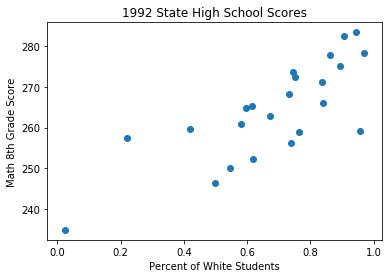

In [25]:
plt.scatter(revs_demo_1992['WH_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of White Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

plt.show()

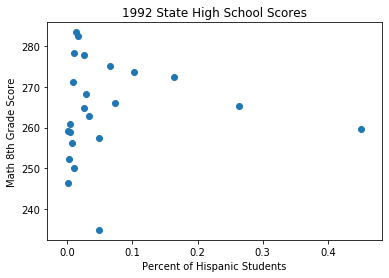

In [26]:
plt.scatter(revs_demo_1992['HI_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Hispanic Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

plt.show()

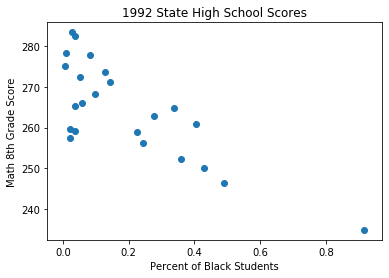

In [27]:
plt.scatter(revs_demo_1992['BL_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Black Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

plt.show()

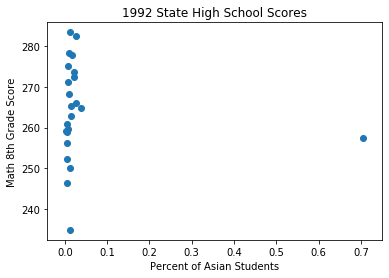

In [28]:
plt.scatter(revs_demo_1992['AS_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Asian Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

plt.show()

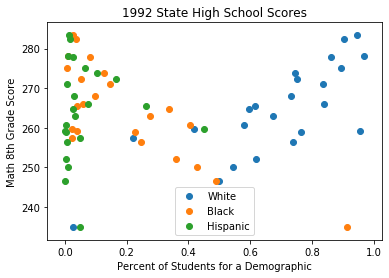

In [29]:
plt.scatter(revs_demo_1992['WH_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.scatter(revs_demo_1992['BL_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.scatter(revs_demo_1992['HI_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Students for a Demographic')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')
plt.legend(('White','Black','Hispanic'))

plt.show()

#### Revenue per student and number of students

revenue per student vs. scores graphs

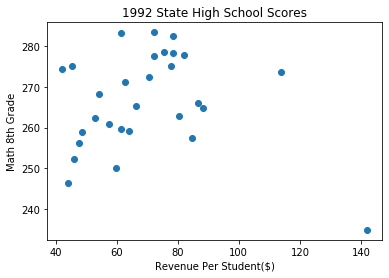

In [30]:
plt.scatter(revs_1992['REVENUE_PER_STUDENT'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Revenue Per Student($)')
plt.ylabel('Math 8th Grade')
plt.title('1992 State High School Scores')

plt.show()

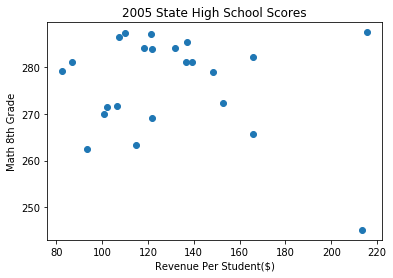

In [31]:
plt.scatter(revs_2005['REVENUE_PER_STUDENT'], revs_2005['AVG_MATH_8_SCORE'])
plt.xlabel('Revenue Per Student($)')
plt.ylabel('Math 8th Grade')
plt.title('2005 State High School Scores')

plt.show()

number of students vs. grades graphs

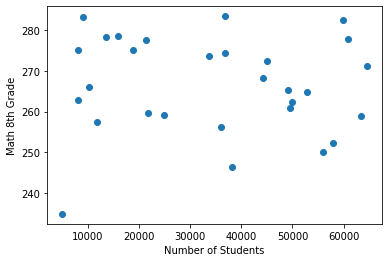

In [32]:
plt.scatter(revs_1992['GRADES_8_G'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Number of Students')
plt.ylabel('Math 8th Grade')

plt.show()

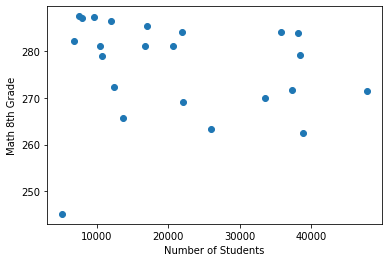

In [33]:
plt.scatter(revs_2005['GRADES_8_G'], revs_2005['AVG_MATH_8_SCORE'])
plt.xlabel('Number of Students')
plt.ylabel('Math 8th Grade')

plt.show()

### 1992 regression

Linear regression with 1992 metrics to test possible issues with regression and how to set it up with a small amount of data.

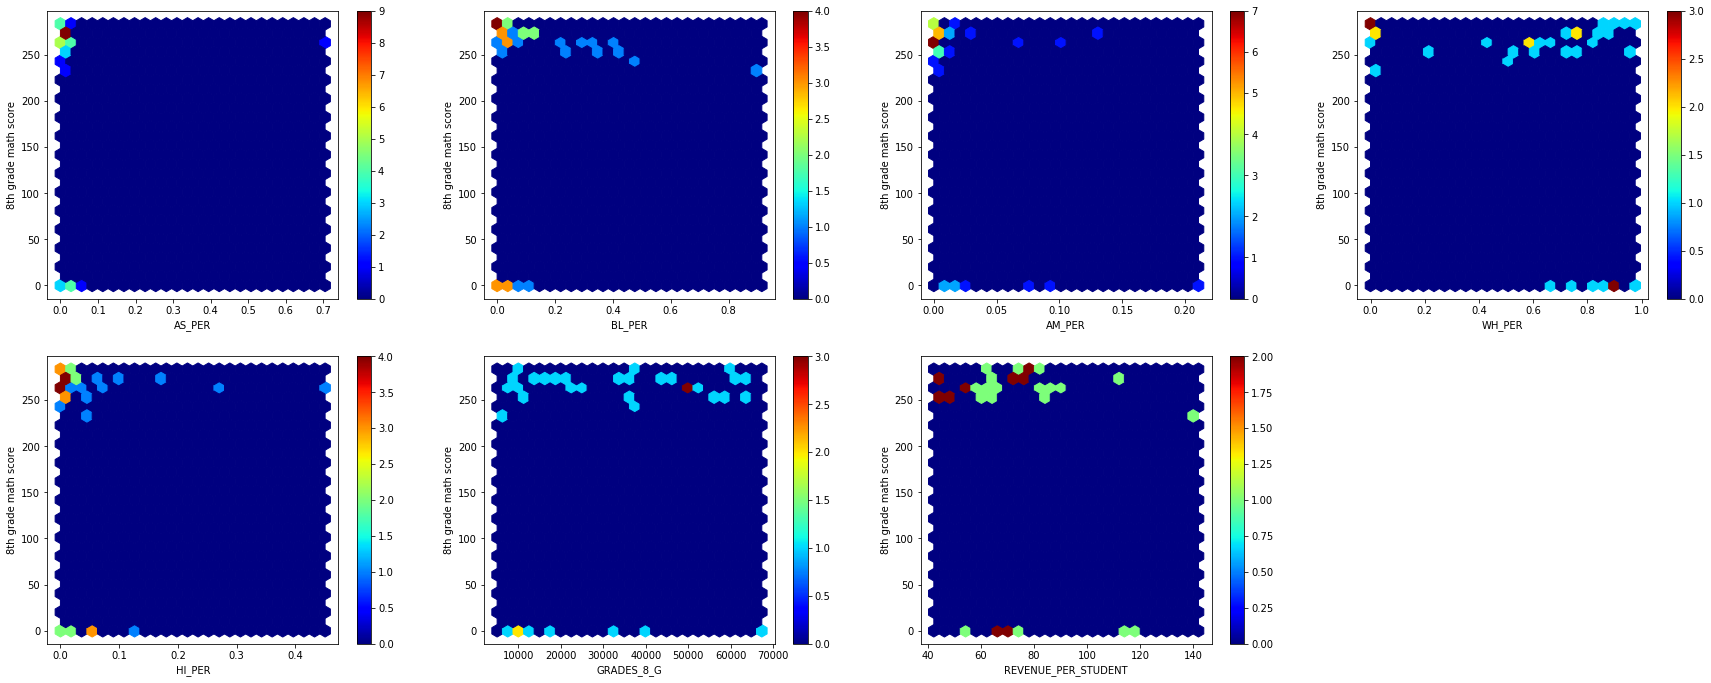

In [34]:
X_education = revs_total_1992.drop(columns=['STATE', 'AVG_MATH_8_SCORE'])
y_education = revs_total_1992['AVG_MATH_8_SCORE']

plt.figure(figsize=(30, 18))
for idx, col in enumerate(X_education):
    plt.subplot(3, 4, idx+1)
    plt.hexbin(X_education[col], y_education, gridsize=25, cmap='jet')
    plt.colorbar()
    plt.xlabel(col)
    plt.ylabel('8th grade math score')

plt.subplots_adjust(wspace=.2)
plt.show()

In [35]:
X_education['bias'] = 1
list(zip(linear_regression(X_education, y_education), X_education.columns))
#AM and HI show high correlations but thats due to low populations not correlation

[(-2.142964331257127, 'AS_PER'),
 (39.36994586959642, 'BL_PER'),
 (-831.3605579593936, 'AM_PER'),
 (-106.52901879798947, 'WH_PER'),
 (205.3259463135374, 'HI_PER'),
 (0.0010019760317803161, 'GRADES_8_G'),
 (-0.28681531753999373, 'REVENUE_PER_STUDENT'),
 (266.50167178002766, 'bias')]